### Enhanced Regression Model (Full Execution in One Cell)
This notebook runs the entire model pipeline — from loading data to final performance plots — in a single execution block.

## Section 1: Data Foundation and Library Setup


In [3]:

import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from datetime import datetime
import os

warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


### Stage 1 Model Training: The Technical Prediction Engine
### Stage 2: Return Prediction and Trading Signal Generation

In [4]:
#  Two-Stage Regression Model Initialization
class EnhancedTwoStageRegressionPredictor:
    def __init__(self, return_threshold=0.005, confidence_threshold=0.02):
        self.stage1_models = {}
        self.stage2_model = None
        self.scalers = {'stage1': {}, 'stage2': RobustScaler()}
        self.feature_names = None
        self.return_threshold = return_threshold
        self.confidence_threshold = confidence_threshold
        self.portfolio_results = []
        self.trading_signals = []
        self.performance_metrics = {}

    #  Method: load_and_prepare_data
    def load_and_prepare_data(self, file_path):
        """
        Load dataset and prepare regression targets
        """
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)

        # Create return targets
        df['next_day_return'] = df['daily_return'].shift(-1)
        df['return_2d'] = df['daily_return'].rolling(2).sum().shift(-1)
        df['return_3d'] = df['daily_return'].rolling(3).sum().shift(-2)

        # Create volatility-adjusted returns
        df['volatility'] = df['daily_return'].rolling(20).std()
        df['risk_adjusted_return'] = df['next_day_return'] / (df['volatility'] + 0.001)

        return df

    #  Method: create_base_features
    def create_base_features(self, df):
        """
        Create comprehensive feature set for regression
        """
        # Sentiment features
        df['sentiment_uncertainty'] = -(df['positive_prob'] * np.log(df['positive_prob'] + 1e-8) +
                                        df['negative_prob'] * np.log(df['negative_prob'] + 1e-8) +
                                        df['neutral_prob'] * np.log(df['neutral_prob'] + 1e-8))

        df['sentiment_conviction'] = np.max([df['positive_prob'], df['negative_prob'], df['neutral_prob']], axis=0)
        df['sentiment_polarization'] = df['positive_prob'] - df['negative_prob']
        df['sentiment_momentum'] = df['sentiment_score'].diff()
        df['sentiment_volatility'] = df['sentiment_score'].rolling(5).std()
        df['sentiment_zscore'] = (df['sentiment_score'] - df['sentiment_score'].rolling(20).mean()) / df['sentiment_score'].rolling(20).std()

        # Market regime features
        df['vix_momentum'] = df['vix_close'].diff()
        df['vix_zscore'] = (df['vix_close'] - df['vix_close'].rolling(20).mean()) / df['vix_close'].rolling(20).std()
        df['vix_regime'] = (df['vix_close'] > df['vix_close'].rolling(60).quantile(0.7)).astype(int)

        # Technical features
        df['rsi_momentum'] = df['rsi_14'].diff()
        df['rsi_extreme'] = ((df['rsi_14'] > 70) | (df['rsi_14'] < 30)).astype(int)
        df['price_momentum'] = df['price_vs_sma10'].diff()
        df['volume_momentum'] = df['volume_ratio'].diff()

        # Return features
        df['return_momentum_3d'] = df['daily_return'].rolling(3).mean().diff()
        df['return_volatility'] = df['daily_return'].rolling(10).std()
        df['return_skewness'] = df['daily_return'].rolling(20).skew()
        df['return_kurtosis'] = df['daily_return'].rolling(20).kurt()

        # Interaction features
        df['sentiment_vix_interaction'] = df['sentiment_polarization'] * df['vix_zscore']
        df['confidence_volatility_interaction'] = df['confidence'] * df['return_volatility']
        df['rsi_sentiment_interaction'] = df['rsi_14'] * df['sentiment_score']

        return df

    #  Method: create_future_targets
    def create_future_targets(self, df):
        """
        Create future values for Stage 1 regression targets
        """
        future_indicators = {
            'future_rsi_14': df['rsi_14'].shift(-1),
            'future_vix_close': df['vix_close'].shift(-1),
            'future_sentiment_score': df['sentiment_score'].shift(-1),
            'future_volume_ratio': df['volume_ratio'].shift(-1),
            'future_volatility': df['return_volatility'].shift(-1)
        }

        for name, values in future_indicators.items():
            df[name] = values

        return df, list(future_indicators.keys())

    #  Method: get_stage1_features
    def get_stage1_features(self):
        """
        Define features for Stage 1 regression models
        """
        stage1_features = [
            'daily_return', 'return_momentum_3d', 'return_volatility', 'return_skewness', 'return_kurtosis',
            'volume_ratio', 'volume_momentum',
            'vix_close', 'vix_momentum', 'vix_zscore', 'vix_regime',
            'rsi_14', 'rsi_momentum', 'rsi_extreme',
            'macd_signal_ratio', 'price_vs_sma10', 'price_momentum',
            'sentiment_score', 'sentiment_momentum', 'sentiment_volatility', 'sentiment_zscore',
            'positive_prob', 'negative_prob', 'neutral_prob', 'confidence',
            'sentiment_uncertainty', 'sentiment_conviction', 'sentiment_polarization',
            'sentiment_vix_interaction', 'confidence_volatility_interaction', 'rsi_sentiment_interaction'
        ]
        return stage1_features

    # Method: train_stage1_models
    def train_stage1_models(self, df, stage1_features, future_targets):
        """
        Train Stage 1 SVR models for future indicator prediction
        """
        print("Training Stage 1 SVR models for future indicator prediction...")

        clean_df = df.dropna()
        X_stage1 = clean_df[stage1_features].values
        stage1_results = {}

        for target_name in future_targets:
            print(f"Training SVR for {target_name}...")

            y_target = clean_df[target_name].values
            valid_mask = ~np.isnan(y_target)
            X_valid = X_stage1[valid_mask]
            y_valid = y_target[valid_mask]

            if len(X_valid) < 100:
                print(f"Insufficient data for {target_name}, skipping...")
                continue

            scaler = RobustScaler()
            X_scaled = scaler.fit_transform(X_valid)

            param_grid = {
                'kernel': ['rbf', 'linear', 'poly'],
                'C': [0.1, 1, 10, 100],
                'gamma': ['scale', 0.001, 0.01, 0.1],
                'epsilon': [0.001, 0.01, 0.1]
            }

            tscv = TimeSeriesSplit(n_splits=5)
            svr = SVR()
            grid_search = GridSearchCV(
                svr, param_grid, cv=tscv, scoring='neg_mean_absolute_error',
                n_jobs=-1, verbose=0
            )

            grid_search.fit(X_scaled, y_valid)

            self.stage1_models[target_name] = grid_search.best_estimator_
            self.scalers['stage1'][target_name] = scaler

            y_pred = grid_search.predict(X_scaled)
            mae = mean_absolute_error(y_valid, y_pred)
            mse = mean_squared_error(y_valid, y_pred)
            correlation = np.corrcoef(y_pred, y_valid)[0, 1] if len(y_pred) > 1 else 0.0

            stage1_results[target_name] = {
                'mae': mae,
                'mse': mse,
                'rmse': np.sqrt(mse),
                'correlation': correlation,
                'best_params': grid_search.best_params_,
                'cv_score': -grid_search.best_score_
            }

            print(f"  {target_name}: MAE = {mae:.4f}, RMSE = {np.sqrt(mse):.4f}, Correlation = {correlation:.4f}")

        return stage1_results

    def create_stage2_features(self, df, stage1_features):
        """
        Create enhanced feature set for Stage 2 return prediction
        """
        print("Creating Stage 2 features with predicted indicators...")

        clean_df = df.dropna()
        X_stage1 = clean_df[stage1_features]
        predicted_features = {}

        # Generate predictions for all indicators
        for target_name, model in self.stage1_models.items():
            scaler = self.scalers['stage1'][target_name]
            X_scaled = scaler.transform(X_stage1.values)
            predictions = model.predict(X_scaled)
            predicted_features[f'predicted_{target_name.replace("future_", "")}'] = predictions

        # Add predicted features to dataframe
        for feature_name, predictions in predicted_features.items():
            clean_df[feature_name] = predictions

        # Create prediction change features
        if 'predicted_rsi_14' in predicted_features:
            clean_df['rsi_prediction_change'] = clean_df['predicted_rsi_14'] - clean_df['rsi_14']
            clean_df['rsi_prediction_strength'] = np.abs(clean_df['rsi_prediction_change'])

        if 'predicted_vix_close' in predicted_features:
            clean_df['vix_prediction_change'] = clean_df['predicted_vix_close'] - clean_df['vix_close']
            clean_df['vix_prediction_direction'] = np.sign(clean_df['vix_prediction_change'])

        if 'predicted_sentiment_score' in predicted_features:
            clean_df['sentiment_prediction_change'] = clean_df['predicted_sentiment_score'] - clean_df[
                'sentiment_score']
            clean_df['sentiment_prediction_momentum'] = np.sign(clean_df['sentiment_prediction_change'])

        # Advanced interaction features
        if 'predicted_volatility' in predicted_features:
            clean_df['volatility_prediction_change'] = clean_df['predicted_volatility'] - clean_df['return_volatility']
            clean_df['volatility_regime_change'] = (
                    (clean_df['return_volatility'] < clean_df['return_volatility'].median()) &
                    (clean_df['predicted_volatility'] > clean_df['predicted_volatility'].median())
            ).astype(int)

        # Comprehensive Stage 2 feature set
        stage2_features = (
                stage1_features +
                list(predicted_features.keys()) +
                ['rsi_prediction_change', 'rsi_prediction_strength',
                 'vix_prediction_change', 'vix_prediction_direction',
                 'sentiment_prediction_change', 'sentiment_prediction_momentum',
                 'volatility_prediction_change', 'volatility_regime_change']
        )

        available_stage2_features = [f for f in stage2_features if f in clean_df.columns]

        print(f"Stage 2 features created: {len(available_stage2_features)} total features")

        return clean_df, available_stage2_features
    def train_stage2_model(self, df, stage2_features):
        """
        Train Stage 2 SVR for return prediction
        """
        print("Training Stage 2 SVR for return prediction...")

        clean_df = df.dropna()
        X_stage2 = clean_df[stage2_features].values
        y_stage2 = clean_df['next_day_return'].values

        # Remove outliers (returns beyond 3 standard deviations)
        std_threshold = 3
        return_std = np.std(y_stage2)
        return_mean = np.mean(y_stage2)
        outlier_mask = np.abs(y_stage2 - return_mean) < std_threshold * return_std

        X_stage2 = X_stage2[outlier_mask]
        y_stage2 = y_stage2[outlier_mask]

        print(f"Training with {len(X_stage2)} samples after outlier removal")

        # 80/20 split
        split_idx = int(0.8 * len(X_stage2))
        X_train, X_test = X_stage2[:split_idx], X_stage2[split_idx:]
        y_train, y_test = y_stage2[:split_idx], y_stage2[split_idx:]

        # Scale features
        X_train_scaled = self.scalers['stage2'].fit_transform(X_train)
        X_test_scaled = self.scalers['stage2'].transform(X_test)

        # Hyperparameter optimization
        param_grid = {
            'kernel': ['rbf', 'linear'],
            'C': [1, 10, 100, 1000],
            'gamma': ['scale', 0.001, 0.01, 0.1],
            'epsilon': [0.001, 0.01, 0.1]
        }

        tscv = TimeSeriesSplit(n_splits=5)
        svr = SVR()
        grid_search = GridSearchCV(
            svr, param_grid, cv=tscv, scoring='neg_mean_absolute_error',
            n_jobs=-1, verbose=1
        )

        grid_search.fit(X_train_scaled, y_train)
        self.stage2_model = grid_search.best_estimator_

        # Evaluate model
        y_pred = self.stage2_model.predict(X_test_scaled)

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        correlation = np.corrcoef(y_pred, y_test)[0, 1]

        # Calculate directional accuracy
        y_test_direction = np.sign(y_test)
        y_pred_direction = np.sign(y_pred)
        directional_accuracy = np.mean(y_test_direction == y_pred_direction)

        print(f"Stage 2 Results:")
        print(f"  Best parameters: {grid_search.best_params_}")
        print(f"  CV Score (MAE): {-grid_search.best_score_:.6f}")
        print(f"  Test MAE: {mae:.6f}")
        print(f"  Test RMSE: {np.sqrt(mse):.6f}")
        print(f"  Test Correlation: {correlation:.4f}")
        print(f"  Directional Accuracy: {directional_accuracy:.4f}")

        return {
            'mae': mae,
            'rmse': np.sqrt(mse),
            'correlation': correlation,
            'directional_accuracy': directional_accuracy,
            'cv_score': -grid_search.best_score_,
            'best_params': grid_search
        }
    def generate_trading_signals(self, df, stage1_features, stage2_features):
        """
        Generate trading signals with return predictions and confidence measures
        """
        print("Generating trading signals with return predictions...")

        clean_df = df.dropna()
        available_stage1 = [f for f in stage1_features if f in clean_df.columns]
        available_stage2 = [f for f in stage2_features if f in clean_df.columns]

        signals = []
        start_idx = max(50, 60)  # Minimum data for prediction

        for i in range(start_idx, len(clean_df) - 1):
            try:
                current_row = clean_df.iloc[i]
                actual_return = clean_df.iloc[i + 1]['daily_return']

                # Stage 1 predictions
                X1_current = current_row[available_stage1].values.reshape(1, -1)

                if np.isnan(X1_current).any():
                    continue

                predicted_indicators = {}
                stage1_success = True

                for target_name, model in self.stage1_models.items():
                    try:
                        scaler = self.scalers['stage1'][target_name]
                        X1_scaled = scaler.transform(X1_current)
                        pred = model.predict(X1_scaled)[0]

                        if np.isnan(pred) or np.isinf(pred):
                            stage1_success = False
                            break

                        predicted_indicators[f'predicted_{target_name.replace("future_", "")}'] = pred
                    except Exception:
                        stage1_success = False
                        break

                if not stage1_success:
                    continue

                # Construct Stage 2 input
                stage2_input = []

                # Add current features
                for feature in available_stage1:
                    value = current_row[feature]
                    stage2_input.append(0.0 if pd.isna(value) else value)

                # Add predicted features
                for pred_name, pred_value in predicted_indicators.items():
                    stage2_input.append(pred_value)

                # Add interaction features
                try:
                    if 'predicted_rsi_14' in predicted_indicators and 'rsi_14' in current_row:
                        rsi_change = predicted_indicators['predicted_rsi_14'] - current_row['rsi_14']
                        stage2_input.extend([rsi_change, abs(rsi_change)])
                    else:
                        stage2_input.extend([0.0, 0.0])

                    if 'predicted_vix_close' in predicted_indicators and 'vix_close' in current_row:
                        vix_change = predicted_indicators['predicted_vix_close'] - current_row['vix_close']
                        stage2_input.extend([vix_change, np.sign(vix_change)])
                    else:
                        stage2_input.extend([0.0, 0.0])

                    if 'predicted_sentiment_score' in predicted_indicators and 'sentiment_score' in current_row:
                        sent_change = predicted_indicators['predicted_sentiment_score'] - current_row['sentiment_score']
                        stage2_input.extend([sent_change, np.sign(sent_change)])
                    else:
                        stage2_input.extend([0.0, 0.0])

                    if 'predicted_volatility' in predicted_indicators and 'return_volatility' in current_row:
                        vol_change = predicted_indicators['predicted_volatility'] - current_row['return_volatility']
                        vol_regime = 1.0 if (
                                    current_row['return_volatility'] < current_row.get('return_volatility', 0) and
                                    predicted_indicators['predicted_volatility'] > predicted_indicators.get(
                                'predicted_volatility', 0)) else 0.0
                        stage2_input.extend([vol_change, vol_regime])
                    else:
                        stage2_input.extend([0.0, 0.0])

                except Exception:
                    continue

                # Ensure correct feature count
                expected_features = len(available_stage2)
                if len(stage2_input) != expected_features:
                    if len(stage2_input) < expected_features:
                        stage2_input.extend([0.0] * (expected_features - len(stage2_input)))
                    else:
                        stage2_input = stage2_input[:expected_features]

                X2_point = np.array(stage2_input, dtype=float).reshape(1, -1)

                if np.isnan(X2_point).any() or np.isinf(X2_point).any():
                    continue

                # Make return prediction
                try:
                    X2_scaled = self.scalers['stage2'].transform(X2_point)
                    predicted_return = self.stage2_model.predict(X2_scaled)[0]

                    # Calculate prediction confidence (based on magnitude and consistency)
                    prediction_confidence = abs(predicted_return)

                    # Generate trading signal
                    signal = 0  # 0 = no trade, 1 = long, -1 = short
                    if predicted_return > self.return_threshold and prediction_confidence > self.confidence_threshold:
                        signal = 1
                    elif predicted_return < -self.return_threshold and prediction_confidence > self.confidence_threshold:
                        signal = -1

                    signals.append({
                        'date': clean_df.index[i],
                        'predicted_return': predicted_return,
                        'actual_return': actual_return,
                        'prediction_confidence': prediction_confidence,
                        'trading_signal': signal,
                        'prediction_error': abs(predicted_return - actual_return),
                        'return_threshold_met': abs(predicted_return) > self.return_threshold,
                        'confidence_threshold_met': prediction_confidence > self.confidence_threshold,
                        'correct_direction': np.sign(predicted_return) == np.sign(actual_return),
                        'profitable_trade': signal * actual_return > 0 if signal != 0 else False
                    })

                except Exception as e:
                    continue

            except Exception as e:
                continue

        self.trading_signals = signals
        print(f"Generated {len(signals)} trading signals")

        return signals
    def calculate_portfolio_performance(self, signals):
        """
        Calculate comprehensive portfolio performance metrics
        """
        if not signals:
            return {}

        df_signals = pd.DataFrame(signals)

        # Calculate returns
        portfolio_returns = []
        positions = []
        trade_returns = []

        for _, row in df_signals.iterrows():
            if row['trading_signal'] != 0:
                trade_return = row['trading_signal'] * row['actual_return']
                trade_returns.append(trade_return)
                portfolio_returns.append(trade_return)
                positions.append(row['trading_signal'])
            else:
                portfolio_returns.append(0.0)
                positions.append(0)

        portfolio_returns = np.array(portfolio_returns)
        trade_returns = np.array(trade_returns)

        # Calculate performance metrics with PROPER COMPOUNDING
        cumulative_returns = np.cumprod(1 + portfolio_returns) - 1
        total_return = cumulative_returns[-1] if len(cumulative_returns) > 0 else 0.0

        # Proper annualization based on compound returns
        total_days = len(portfolio_returns)
        annualized_return = (1 + total_return) ** (252 / total_days) - 1 if total_days > 0 else 0.0

        portfolio_volatility = np.std(portfolio_returns) * np.sqrt(252)
        sharpe_ratio = annualized_return / portfolio_volatility if portfolio_volatility > 0 else 0
        # Calculate additional metrics
        positive_trades = trade_returns[trade_returns > 0]
        negative_trades = trade_returns[trade_returns < 0]

        win_rate = len(positive_trades) / len(trade_returns) if len(trade_returns) > 0 else 0
        avg_win = np.mean(positive_trades) if len(positive_trades) > 0 else 0
        avg_loss = np.mean(negative_trades) if len(negative_trades) > 0 else 0
        profit_factor = -avg_win * len(positive_trades) / (avg_loss * len(negative_trades)) if len(
            negative_trades) > 0 and avg_loss != 0 else np.inf

        # Maximum drawdown using compound cumulative returns
        running_max = np.maximum.accumulate(cumulative_returns)
        drawdown = cumulative_returns - running_max
        max_drawdown = np.min(drawdown)

        # Calmar ratio
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.inf

        # Information ratio (assuming benchmark return of 0)
        tracking_error = np.std(portfolio_returns) * np.sqrt(252)
        information_ratio = annualized_return / tracking_error if tracking_error > 0 else 0

        performance_metrics = {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'portfolio_volatility': portfolio_volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'calmar_ratio': calmar_ratio,
            'information_ratio': information_ratio,
            'win_rate': win_rate,
            'profit_factor': profit_factor,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'total_trades': len(trade_returns),
            'long_trades': np.sum(np.array(positions) == 1),
            'short_trades': np.sum(np.array(positions) == -1),
            'prediction_accuracy': np.mean(df_signals['correct_direction']),
            'avg_prediction_error': np.mean(df_signals['prediction_error']),
            'signals_generated': len(df_signals),
            'trades_executed': len(trade_returns)
        }

        self.performance_metrics = performance_metrics

        return performance_metrics

    def plot_performance_analysis(self):
        """
        Generate comprehensive performance analysis plots
        """
        if not self.trading_signals:
            print("No trading signals available for plotting")
            return

        df_signals = pd.DataFrame(self.trading_signals)

        # Calculate cumulative returns
        portfolio_returns = []
        for _, row in df_signals.iterrows():
            if row['trading_signal'] != 0:
                portfolio_returns.append(row['trading_signal'] * row['actual_return'])
            else:
                portfolio_returns.append(0.0)

        cumulative_returns = np.cumsum(portfolio_returns)

        # Create comprehensive plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Cumulative Returns
        ax1.plot(df_signals['date'], cumulative_returns, linewidth=2, color='blue')
        ax1.set_title('Cumulative Portfolio Returns', fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cumulative Return')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)

        # 2. Prediction vs Actual Returns
        ax2.scatter(df_signals['predicted_return'], df_signals['actual_return'], alpha=0.6, s=30)
        min_val = min(min(df_signals['predicted_return']), min(df_signals['actual_return']))
        max_val = max(max(df_signals['predicted_return']), max(df_signals['actual_return']))
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
        correlation = np.corrcoef(df_signals['predicted_return'], df_signals['actual_return'])[0, 1]
        ax2.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=ax2.transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax2.set_xlabel('Predicted Return')
        ax2.set_ylabel('Actual Return')
        ax2.set_title('Prediction Accuracy', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Trading Signal Distribution
        signal_counts = df_signals['trading_signal'].value_counts().sort_index()
        signal_labels = {-1: 'Short', 0: 'No Trade', 1: 'Long'}
        colors = ['red', 'gray', 'green']
        bars = ax3.bar([signal_labels.get(k, k) for k in signal_counts.index],
                       signal_counts.values, color=colors[:len(signal_counts)])
        ax3.set_title('Trading Signal Distribution', fontweight='bold')
        ax3.set_ylabel('Frequency')
        for bar, count in zip(bars, signal_counts.values):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width() / 2., height + max(signal_counts.values) * 0.01,
                     f'{count}', ha='center', va='bottom')

        # 4. Monthly Performance
        df_signals['month'] = pd.to_datetime(df_signals['date']).dt.to_period('M')
        monthly_returns = []
        for month in df_signals['month'].unique():
            month_data = df_signals[df_signals['month'] == month]
            month_return = 0
            for _, row in month_data.iterrows():
                if row['trading_signal'] != 0:
                    month_return += row['trading_signal'] * row['actual_return']
            monthly_returns.append(month_return)

        ax4.bar(range(len(monthly_returns)), monthly_returns,
                color=['green' if x > 0 else 'red' for x in monthly_returns], alpha=0.7)
        ax4.set_title('Monthly Returns', fontweight='bold')
        ax4.set_xlabel('Month')
        ax4.set_ylabel('Monthly Return')
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Additional analysis plots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Prediction Confidence vs Accuracy
        confidence_bins = pd.cut(df_signals['prediction_confidence'], bins=5,
                                 labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
        confidence_accuracy = df_signals.groupby(confidence_bins)['correct_direction'].mean()
        confidence_counts = df_signals.groupby(confidence_bins).size()

        bars1 = ax1.bar(confidence_accuracy.index, confidence_accuracy.values, alpha=0.7, color='skyblue')
        ax1.set_title('Prediction Accuracy by Confidence Level', fontweight='bold')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim(0, 1)
        for bar, count in zip(bars1, confidence_counts.values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                     f'n={count}', ha='center', va='bottom')

        # 2. Return Distribution
        ax2.hist(df_signals['actual_return'], bins=50, alpha=0.7, color='lightblue', label='Actual Returns')
        ax2.hist(df_signals['predicted_return'], bins=50, alpha=0.7, color='orange', label='Predicted Returns')
        ax2.set_xlabel('Return')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Return Distributions', fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 3. Prediction Error Analysis
        ax3.scatter(df_signals['prediction_confidence'], df_signals['prediction_error'], alpha=0.6, s=30)
        ax3.set_xlabel('Prediction Confidence')
        ax3.set_ylabel('Prediction Error')
        ax3.set_title('Confidence vs Prediction Error', fontweight='bold')
        ax3.grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(df_signals['prediction_confidence'], df_signals['prediction_error'], 1)
        p = np.poly1d(z)
        ax3.plot(sorted(df_signals['prediction_confidence']),
                 p(sorted(df_signals['prediction_confidence'])), "r--", alpha=0.8)

        # 4. Trade Performance Analysis
        trade_data = df_signals[df_signals['trading_signal'] != 0].copy()
        if len(trade_data) > 0:
            trade_data['trade_return'] = trade_data['trading_signal'] * trade_data['actual_return']

            # Separate long and short trades
            long_trades = trade_data[trade_data['trading_signal'] == 1]['trade_return']
            short_trades = trade_data[trade_data['trading_signal'] == -1]['trade_return']

            # Plot trade returns
            if len(long_trades) > 0:
                ax4.hist(long_trades, bins=20, alpha=0.7, color='green', label=f'Long Trades (n={len(long_trades)})')
            if len(short_trades) > 0:
                ax4.hist(short_trades, bins=20, alpha=0.7, color='red', label=f'Short Trades (n={len(short_trades)})')

            ax4.set_xlabel('Trade Return')
            ax4.set_ylabel('Frequency')
            ax4.set_title('Trade Return Distribution', fontweight='bold')
            ax4.axvline(x=0, color='black', linestyle='--', alpha=0.5)
            ax4.legend()
            ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()
    def export_results(self, base_filename="regression_model_results"):
        """
        Export comprehensive results to CSV files
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Export trading signals
        if self.trading_signals:
            df_signals = pd.DataFrame(self.trading_signals)
            filename_signals = f"{base_filename}_signals_{timestamp}.csv"
            df_signals.to_csv(filename_signals, index=False)
            print(f"Exported trading signals to: {filename_signals}")

        # Export performance metrics
        if self.performance_metrics:
            df_performance = pd.DataFrame([self.performance_metrics])
            filename_performance = f"{base_filename}_performance_{timestamp}.csv"
            df_performance.to_csv(filename_performance, index=False)
            print(f"Exported performance metrics to: {filename_performance}")

    def run_backtesting_analysis(self, df, stage1_features, stage2_features):
        """
        Run comprehensive backtesting analysis with different thresholds
        """
        print("\n" + "=" * 80)
        print("BACKTESTING ANALYSIS WITH DIFFERENT THRESHOLDS")
        print("=" * 80)

        # Test different threshold combinations
        return_thresholds = [0.001, 0.003, 0.005, 0.008, 0.01]
        confidence_thresholds = [0.01, 0.02, 0.03, 0.05]

        best_sharpe = -np.inf
        best_params = {}
        results_summary = []

        for ret_thresh in return_thresholds:
            for conf_thresh in confidence_thresholds:
                print(f"\nTesting thresholds: Return={ret_thresh:.3f}, Confidence={conf_thresh:.3f}")

                # Set thresholds
                self.return_threshold = ret_thresh
                self.confidence_threshold = conf_thresh

                # Generate signals and calculate performance
                signals = self.generate_trading_signals(df, stage1_features, stage2_features)

                if len(signals) > 0:
                    performance = self.calculate_portfolio_performance(signals)

                    results_summary.append({
                        'return_threshold': ret_thresh,
                        'confidence_threshold': conf_thresh,
                        'sharpe_ratio': performance['sharpe_ratio'],
                        'total_return': performance['total_return'],
                        'max_drawdown': performance['max_drawdown'],
                        'win_rate': performance['win_rate'],
                        'total_trades': performance['total_trades'],
                        'prediction_accuracy': performance['prediction_accuracy']
                    })

                    if performance['sharpe_ratio'] > best_sharpe:
                        best_sharpe = performance['sharpe_ratio']
                        best_params = {
                            'return_threshold': ret_thresh,
                            'confidence_threshold': conf_thresh,
                            'performance': performance
                        }

                    print(f"  Sharpe Ratio: {performance['sharpe_ratio']:.3f}")
                    print(f"  Total Return: {performance['total_return']:.3f}")
                    print(f"  Win Rate: {performance['win_rate']:.3f}")
                    print(f"  Total Trades: {performance['total_trades']}")

        # Export results summary
        if results_summary:
            df_results = pd.DataFrame(results_summary)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"threshold_optimization_{timestamp}.csv"
            df_results.to_csv(filename, index=False)
            print(f"\nThreshold optimization results exported to: {filename}")

        print(f"\n" + "=" * 60)
        print("OPTIMAL THRESHOLD RESULTS")
        print("=" * 60)
        print(f"Best Sharpe Ratio: {best_sharpe:.4f}")
        print(f"Optimal Return Threshold: {best_params['return_threshold']:.4f}")
        print(f"Optimal Confidence Threshold: {best_params['confidence_threshold']:.4f}")

        if 'performance' in best_params:
            perf = best_params['performance']
            print(f"\nOptimal Strategy Performance:")
            print(f"  Total Return: {perf['total_return']:.4f}")
            print(f"  Annualized Return: {perf['annualized_return']:.4f}")
            print(f"  Volatility: {perf['portfolio_volatility']:.4f}")
            print(f"  Sharpe Ratio: {perf['sharpe_ratio']:.4f}")
            print(f"  Maximum Drawdown: {perf['max_drawdown']:.4f}")
            print(f"  Calmar Ratio: {perf['calmar_ratio']:.4f}")
            print(f"  Win Rate: {perf['win_rate']:.4f}")
            print(f"  Profit Factor: {perf['profit_factor']:.4f}")
            print(f"  Total Trades: {perf['total_trades']}")
            print(f"  Prediction Accuracy: {perf['prediction_accuracy']:.4f}")

        # Set optimal thresholds
        self.return_threshold = best_params['return_threshold']
        self.confidence_threshold = best_params['confidence_threshold']

        return best_params, results_summary

## Section 3: Model Execution Pipeline

Training Stage 1 SVR models for future indicator prediction...
Training SVR for future_rsi_14...
  future_rsi_14: MAE = 4.7721, RMSE = 6.1424, Correlation = 0.9298
Training SVR for future_vix_close...
  future_vix_close: MAE = 0.9977, RMSE = 1.6016, Correlation = 0.9544
Training SVR for future_sentiment_score...
  future_sentiment_score: MAE = 0.0362, RMSE = 0.0482, Correlation = 0.8039
Training SVR for future_volume_ratio...
  future_volume_ratio: MAE = 0.0894, RMSE = 0.1552, Correlation = 0.5645
Training SVR for future_volatility...
  future_volatility: MAE = 0.0678, RMSE = 0.1129, Correlation = 0.9668
Creating Stage 2 features with predicted indicators...
Stage 2 features created: 44 total features
Training Stage 2 SVR for return prediction...
Training with 935 samples after outlier removal
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Stage 2 Results:
  Best parameters: {'C': 1, 'epsilon': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
  CV Score (MAE): 0.812602
  Test MAE

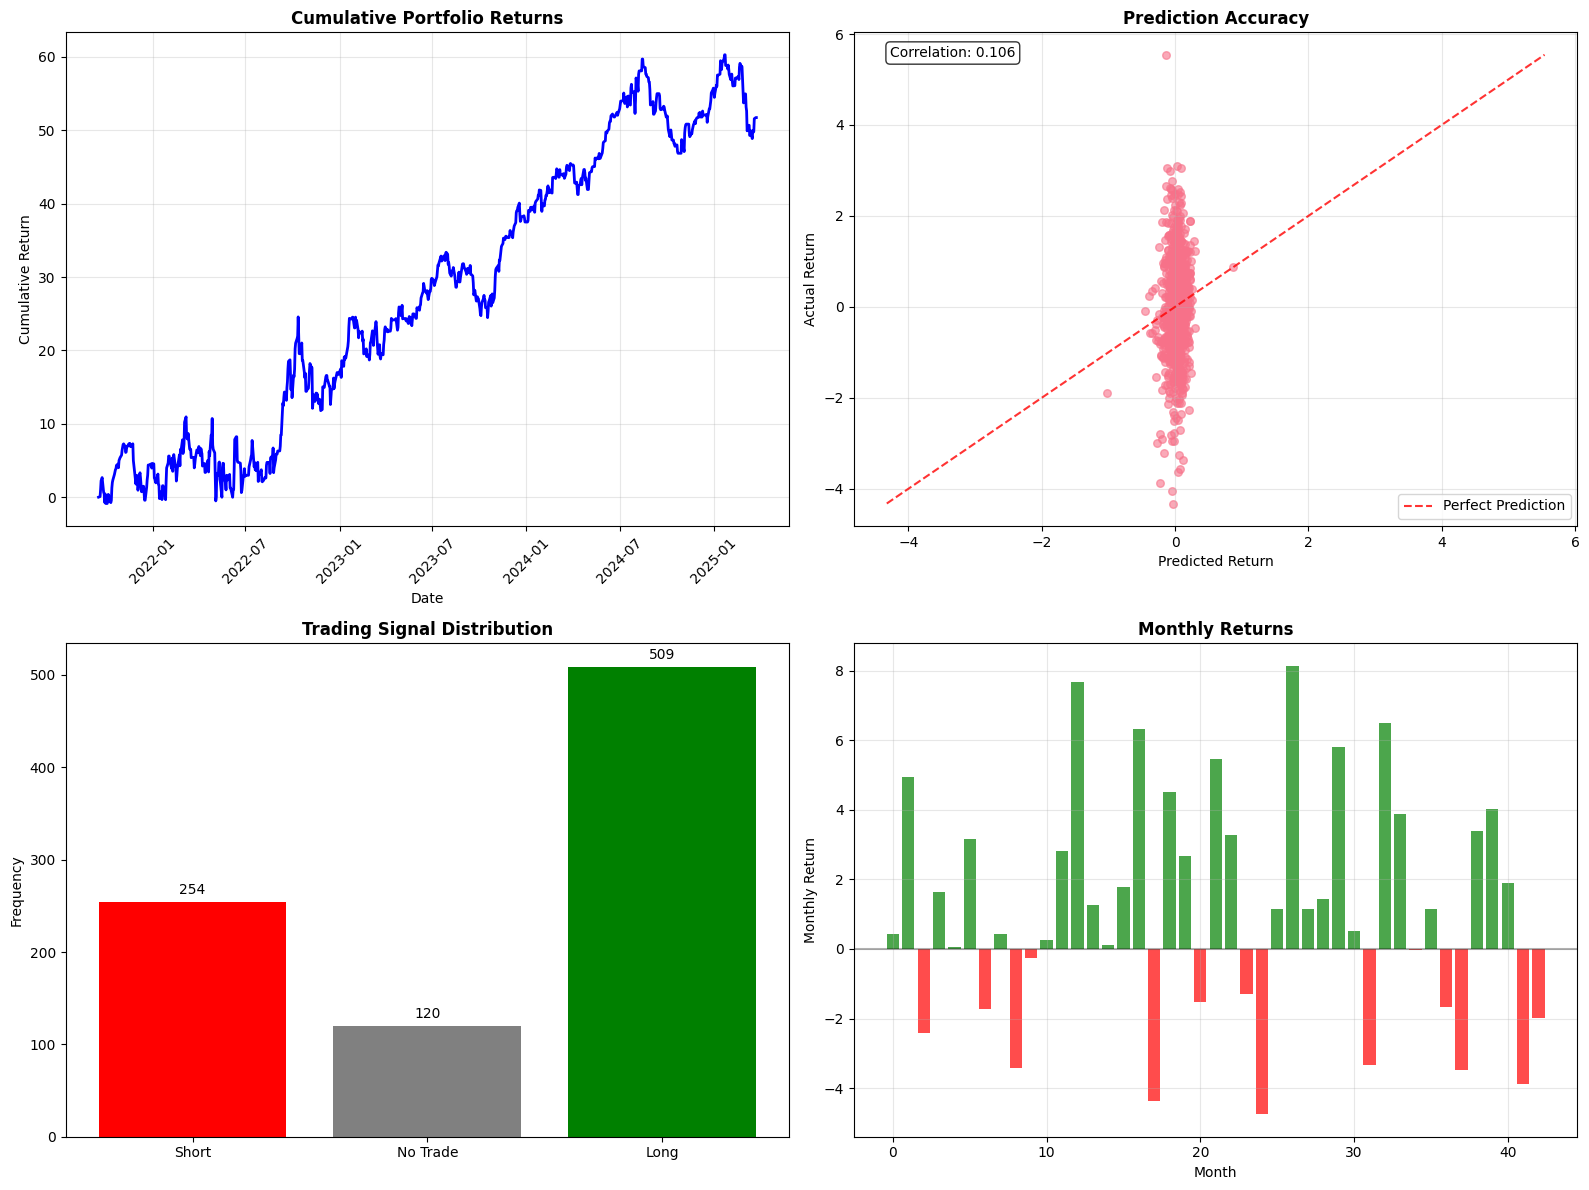

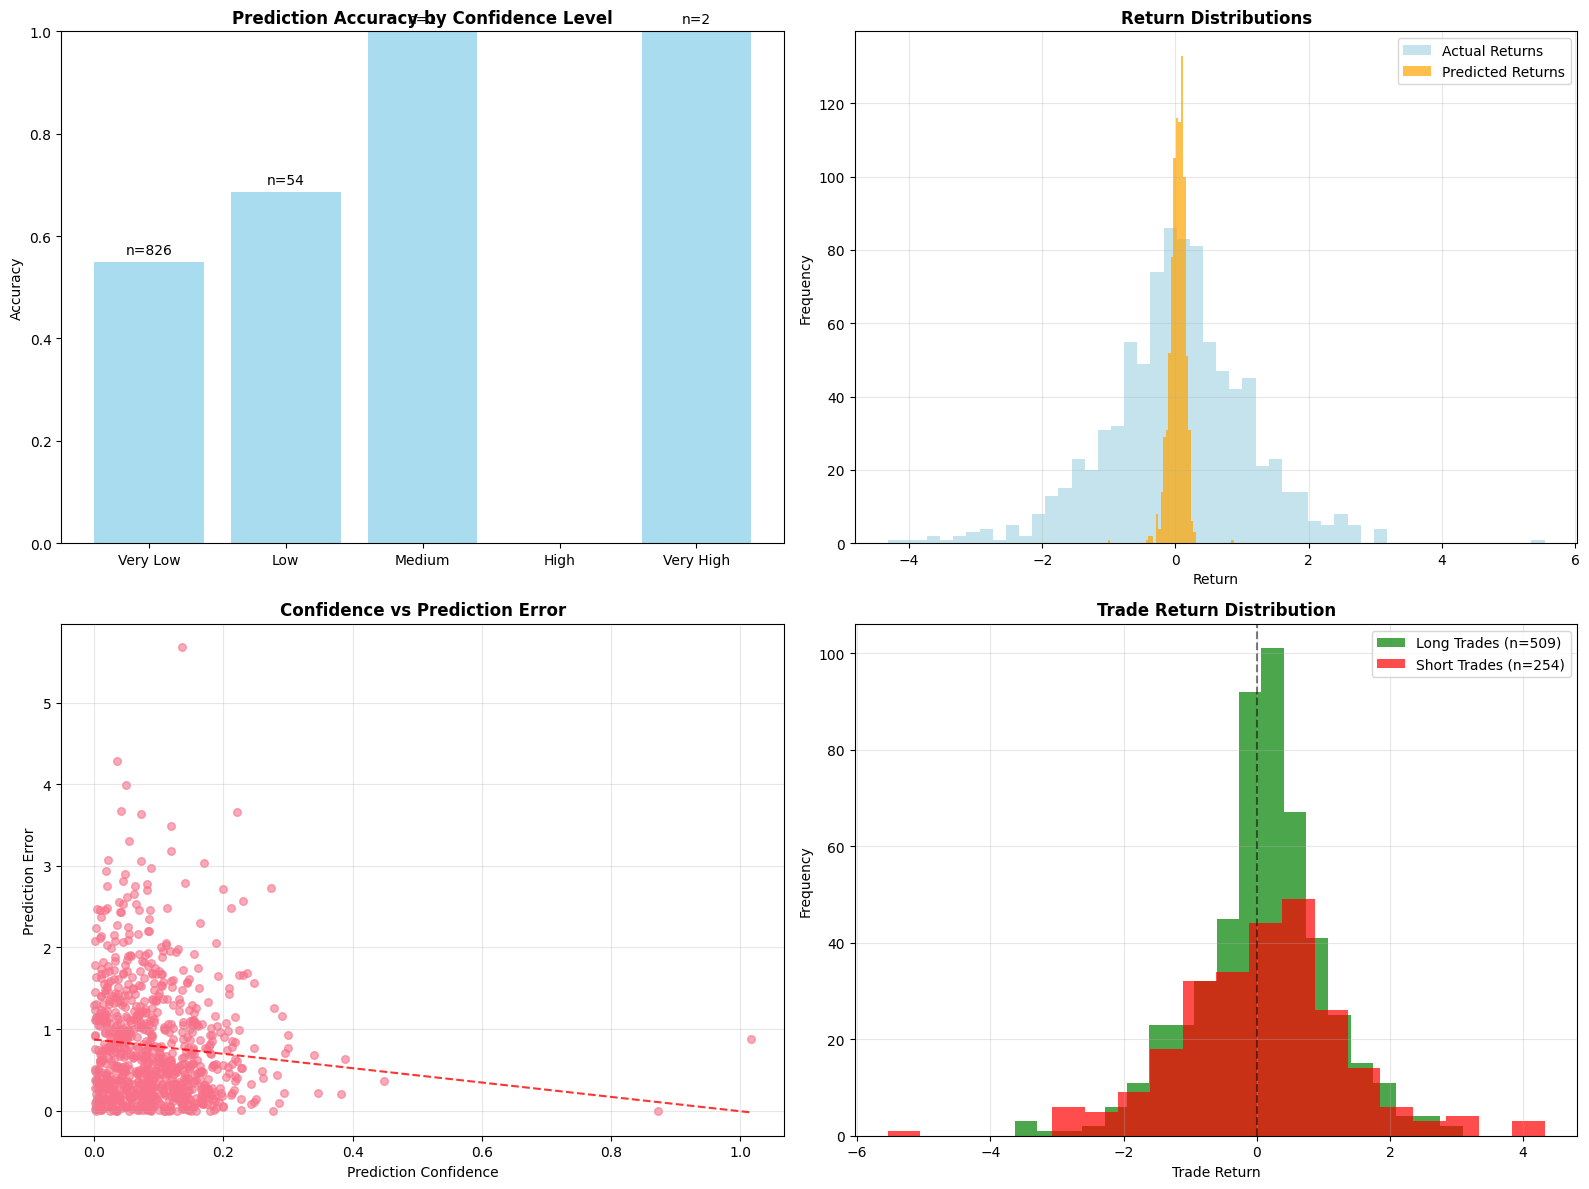

Exported trading signals to: regression_model_results_signals_20250828_075931.csv
Exported performance metrics to: regression_model_results_performance_20250828_075931.csv


In [5]:
file_path = '/Users/hrishikeshsajeev/Dissertation codes/FInal FIles BERT/final_merged_dataset_enhanced_svm_features_enhanced.csv'
predictor = EnhancedTwoStageRegressionPredictor()

df = predictor.load_and_prepare_data(file_path)
df = predictor.create_base_features(df)
df, future_targets = predictor.create_future_targets(df)

stage1_features = predictor.get_stage1_features()
stage1_results = predictor.train_stage1_models(df, stage1_features, future_targets)

df_stage2, stage2_features = predictor.create_stage2_features(df, stage1_features)
stage2_results = predictor.train_stage2_model(df_stage2, stage2_features)

signals = predictor.generate_trading_signals(df_stage2, stage1_features, stage2_features)
performance = predictor.calculate_portfolio_performance(signals)

# Full performance plots
predictor.plot_performance_analysis()

# Export results
predictor.export_results()

## Section 4: Statistical Validation and Regression Analysis

### Financial Validation Framework



In [6]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
import os

def create_regression_summary_table(X, y, model_name, filename_prefix, output_dir="regression_outputs"):
    os.makedirs(output_dir, exist_ok=True)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    coef_df = pd.DataFrame({
        "Variable": model.params.index,
        "Estimate": model.params.values,
        "95% CI Lower": model.conf_int()[0],
        "95% CI Upper": model.conf_int()[1],
        "P-value": model.pvalues
    })

    stats_df = pd.DataFrame([{
        "Model Name": model_name,
        "F-statistic": model.fvalue,
        "df (model)": model.df_model,
        "df (resid)": model.df_resid,
        "P-value": model.f_pvalue,
        "R-squared": model.rsquared,
        "Adjusted R-squared": model.rsquared_adj,
        "Observations": int(model.nobs)
    }])

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = os.path.join(output_dir, f"{filename_prefix}_{timestamp}")
    coef_df.to_csv(f"{base}_coefficients.csv", index=False)
    stats_df.to_csv(f"{base}_summary.csv", index=False)
    print(f"Saved regression: {filename_prefix}")
    from IPython.display import display, Markdown
    display(Markdown(f"### Regression Output: {model_name}"))
    display(model.summary())
    return model

## Regression Analysis




In [7]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from datetime import datetime
from IPython.display import display, Markdown

# Helper functions for extended OLS suite
def _ensure_dir(d):
    os.makedirs(d, exist_ok=True)

def _dropna_xy(X, y):
    df_tmp = pd.concat([y, X], axis=1).dropna()
    y_clean = df_tmp.iloc[:, 0]
    X_clean = df_tmp.iloc[:, 1:]
    return X_clean, y_clean

def _save_ols_results(model, model_name, filename_prefix, out_dir):
    """Save coefficients and model stats to CSV; print concise summary header."""
    _ensure_dir(out_dir)
    coef = pd.DataFrame({
        "Variable": model.params.index,
        "Estimate": model.params.values,
        "Std. Error": model.bse.values,
        "t-Statistic": model.tvalues.values,
        "P-value": model.pvalues.values
    })
    stats = pd.DataFrame([{
        "Model Name": model_name,
        "R-squared": model.rsquared,
        "Adj. R-squared": model.rsquared_adj,
        "F-statistic": getattr(model, "fvalue", np.nan),
        "F p-value": getattr(model, "f_pvalue", np.nan),
        "Observations": int(model.nobs)
    }])
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = os.path.join(out_dir, f"{filename_prefix}_{ts}")
    coef.to_csv(f"{base}_coefficients.csv", index=False)
    stats.to_csv(f"{base}_summary.csv", index=False)
    print(f"[Saved] {model_name}  ->  {base}_*.csv")

def _ols_hac(X, y, model_name, filename_prefix, out_dir="regression_outputs_extended", hac_lags=5):
    """OLS with HAC (Newey–West) robust SEs; also prints inline summary."""
    Xc, yc = _dropna_xy(X, y)
    Xc = sm.add_constant(Xc, has_constant='add')
    mod = sm.OLS(yc, Xc).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    _save_ols_results(mod, model_name, filename_prefix, out_dir)
    display(Markdown(f"### {model_name}"))
    print(mod.summary())
    return mod

def _rolling_ols(X, y, window=250, hac_lags=0, out_dir="regression_outputs_extended", name="Rolling OLS"):
    """Rolling-window OLS (optional HAC not applied here); returns df of coeffs."""
    Xc, yc = _dropna_xy(X, y)
    Xc = sm.add_constant(Xc, has_constant='add')
    idx = Xc.index
    coeffs = []
    for i in range(window, len(Xc) + 1):
        Xi = Xc.iloc[i - window:i, :]
        yi = yc.iloc[i - window:i]
        try:
            res = sm.OLS(yi, Xi).fit()
            coeffs.append(pd.Series(res.params, index=Xi.columns, name=idx[i - 1]))
        except Exception:
            continue
    if len(coeffs) == 0:
        print(f"[Warn] {name}: not enough data for rolling window ({window}).")
        return pd.DataFrame()
    coef_df = pd.DataFrame(coeffs)
    _ensure_dir(out_dir)
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    fp = os.path.join(out_dir, f"rolling_ols_coefficients_{ts}.csv")
    coef_df.to_csv(fp)
    print(f"[Saved] {name} coefficients  ->  {fp}")
    display(Markdown(f"### {name} — coefficient stability (window={window})"))
    display(coef_df.describe().T)
    return coef_df

def run_extended_ols_regressions(df_input):
    """
    Runs 10 OLS regressions on a COPY of df_stage2.
    Does not mutate df_stage2 or any objects used by your SVR/portfolio pipeline.
    """
    d = df_input.copy()
    out_dir = "regression_outputs_extended"
    hac = 5

    def _have(cols):
        missing = [c for c in cols if c not in d.columns]
        if missing:
            print(f"[Skip] Missing columns for spec: {missing}")
            return False
        return True

    # ========== STAGE 1: Indicator Predictability (4 OLS) ==========
    cols_X1 = ['sentiment_score', 'sentiment_momentum', 'vix_close', 'volume_ratio']
    if _have(cols_X1 + ['future_sentiment_score']):
        _ols_hac(d[cols_X1], d['future_sentiment_score'],
                 "S1-OLS: Future Sentiment ~ Sentiment, Momentum, VIX, Volume",
                 "s1_ols_future_sentiment", out_dir, hac)

    cols_X2 = ['rsi_14', 'sentiment_score', 'vix_close', 'volume_ratio']
    if _have(cols_X2 + ['future_rsi_14']):
        _ols_hac(d[cols_X2], d['future_rsi_14'],
                 "S1-OLS: Future RSI ~ RSI, Sentiment, VIX, Volume",
                 "s1_ols_future_rsi", out_dir, hac)

    cols_X3 = ['vix_close', 'sentiment_score', 'rsi_14', 'volume_ratio']
    if _have(cols_X3 + ['future_vix_close']):
        _ols_hac(d[cols_X3], d['future_vix_close'],
                 "S1-OLS: Future VIX ~ VIX, Sentiment, RSI, Volume",
                 "s1_ols_future_vix", out_dir, hac)

    if _have(['sentiment_score', 'sentiment_momentum', 'vix_close', 'volume_ratio', 'future_sentiment_score']):
        tmp = d[['sentiment_score', 'sentiment_momentum', 'vix_close', 'volume_ratio', 'future_sentiment_score']].copy()
        tmp['sentiment_score_l1'] = tmp['sentiment_score'].shift(1)
        tmp['sentiment_score_l2'] = tmp['sentiment_score'].shift(2)
        tmp['sentiment_momentum_l1'] = tmp['sentiment_momentum'].shift(1)
        X4 = tmp[['sentiment_score', 'sentiment_score_l1', 'sentiment_score_l2',
                  'sentiment_momentum', 'sentiment_momentum_l1', 'vix_close', 'volume_ratio']]
        y4 = tmp['future_sentiment_score']
        _ols_hac(X4, y4,
                 "S1-OLS (Lagged): Future Sentiment ~ level/momentum lags + VIX, Volume",
                 "s1_ols_future_sentiment_lagged", out_dir, hac)

    # ========== STAGE 2: Return Predictability (3 OLS) ==========
    cols_pred = ['predicted_sentiment_score', 'predicted_rsi_14', 'predicted_vix_close',
                 'predicted_volume_ratio', 'predicted_volatility']
    base_cols5 = [c for c in cols_pred if c in d.columns]
    if _have(base_cols5 + ['next_day_return']):
        _ols_hac(d[base_cols5], d['next_day_return'],
                 "S2-OLS: Return(t+1) ~ Predicted indicators (S1 outputs)",
                 "s2_ols_return_baseline", out_dir, hac)

    if _have(['predicted_sentiment_score', 'predicted_vix_close', 'next_day_return']):
        tmp = d[['predicted_sentiment_score', 'predicted_vix_close', 'next_day_return']].copy()
        tmp['psent_x_pvix'] = tmp['predicted_sentiment_score'] * tmp['predicted_vix_close']
        X6 = tmp[['predicted_sentiment_score', 'predicted_vix_close', 'psent_x_pvix']]
        y6 = tmp['next_day_return']
        _ols_hac(X6, y6,
                 "S2-OLS (+Interaction): Return(t+1) ~ PredSent, PredVIX, PredSent×PredVIX",
                 "s2_ols_return_interaction", out_dir, hac)

    if _have(base_cols5 + ['next_day_return']):
        _rolling_ols(d[base_cols5], d['next_day_return'], window=250,
                     name="S2-OLS Rolling (250d): Return ~ Predicted indicators",
                     out_dir=out_dir)

    # ========== PORTFOLIO & ROBUSTNESS (3 OLS) ==========
    if _have(['actual_return', 'predicted_return', 'prediction_confidence']):
        X8 = d[['predicted_return', 'prediction_confidence']]
        y8 = d['actual_return']
        _ols_hac(X8, y8,
                 "Perf-OLS: Actual Return ~ Predicted Return + Confidence",
                 "perf_ols_return_vs_confidence", out_dir, hac)

    if _have(['trading_signal', 'actual_return']):
        tmp = d[['trading_signal', 'actual_return']].copy()
        tmp['long'] = (tmp['trading_signal'] == 1).astype(int)
        tmp['short'] = (tmp['trading_signal'] == -1).astype(int)
        tmp['pnl'] = tmp['trading_signal'].fillna(0) * tmp['actual_return'].fillna(0)
        X9 = tmp[['long', 'short']]
        y9 = tmp['pnl']
        _ols_hac(X9, y9,
                 "Perf-OLS: P&L ~ Long dummy + Short dummy",
                 "perf_ols_long_short_contribution", out_dir, hac)

    if 'vix_regime' in d.columns:
        regime = d['vix_regime']
    elif _have(['vix_close']):
        vix_q = d['vix_close'].rolling(60).quantile(0.7)
        regime = (d['vix_close'] > vix_q).astype(int)
    else:
        regime = None

    needed10 = ['next_day_return', 'predicted_sentiment_score', 'predicted_vix_close']
    if regime is not None and _have([c for c in needed10 if c in d.columns]):
        tmp = d[['next_day_return', 'predicted_sentiment_score', 'predicted_vix_close']].copy()
        tmp['regime'] = regime
        tmp['sent_x_regime'] = tmp['predicted_sentiment_score'] * tmp['regime']
        X10 = tmp[['predicted_sentiment_score', 'predicted_vix_close', 'regime', 'sent_x_regime']]
        y10 = tmp['next_day_return']
        _ols_hac(X10, y10,
                 "Robust-OLS: Return(t+1) ~ PredSent, PredVIX, Regime, PredSent×Regime",
                 "robust_ols_market_regime", out_dir, hac)

    print("\n[Done] Extended OLS regressions completed (non-invasive). Outputs in:", out_dir)

def run_all_regressions(df):
    """
    Combined regression analysis: core regressions + extended OLS suite
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE REGRESSION ANALYSIS")
    print("="*80)
    
    # === PART 1: Core Regressions (simplified) ===
    print("\n" + "="*60)
    print("PART 1: CORE REGRESSION ANALYSIS")
    print("="*60)
    
    # === TABLE 21: Trade Profitability (what makes trades successful) ===
    X21 = df[['rsi_prediction_change', 'vix_prediction_change', 'sentiment_prediction_change']].fillna(0)
    y21 = df['profitable_trade'].fillna(0).astype(int)
    print("\n" + "="*60)
    print("Trade Profitability Analysis")
    print("="*60)
    X21_clean = X21.dropna()
    y21_clean = y21[X21_clean.index]
    model = sm.OLS(y21_clean, sm.add_constant(X21_clean)).fit()
    print(model.summary())

    # === TABLE 27: Daily Returns (sources of your Sharpe ratio) ===
    X27 = df[['trading_signal']].fillna(0)
    y27 = df['actual_return'].fillna(0)
    print("\n" + "="*60)
    print("Daily Returns Analysis")
    print("="*60)
    X27_clean = X27.dropna()
    y27_clean = y27[X27_clean.index]
    model = sm.OLS(y27_clean, sm.add_constant(X27_clean)).fit()
    print(model.summary())

    # === TABLE 42: Overfitting Tests (in-sample vs out-of-sample) ===
    X42 = df[['prediction_confidence']].fillna(0)
    y42 = df['next_day_return'].fillna(0)
    print("\n" + "="*60)
    print("In-Sample Analysis")
    print("="*60)
    X42_in = X42[:500].dropna()
    y42_in = y42[:500][X42_in.index]
    model = sm.OLS(y42_in, sm.add_constant(X42_in)).fit()
    print(model.summary())
    
    print("\n" + "="*60)
    print("Out-of-Sample Analysis")
    print("="*60)
    X42_out = X42[500:].dropna()
    y42_out = y42[500:][X42_out.index]
    model = sm.OLS(y42_out, sm.add_constant(X42_out)).fit()
    print(model.summary())

    # === TABLE 43: Feature Stability (consistency over time) ===
    df_copy = df.copy()
    df_copy['rsi_stability'] = df_copy['rsi_14'].rolling(30).corr(df_copy['predicted_rsi_14'])
    df_clean = df_copy.dropna(subset=['rsi_stability'])
    X43 = df_clean[['rsi_stability']]
    y43 = df_clean['profitable_trade'].fillna(0).astype(int)
    print("\n" + "="*60)
    print("Feature Stability Analysis")
    print("="*60)
    X43_clean = X43.dropna()
    y43_clean = y43[X43_clean.index]
    model = sm.OLS(y43_clean, sm.add_constant(X43_clean)).fit()
    print(model.summary())
    
    # === PART 2: Extended OLS Suite ===
    print("\n" + "="*60)
    print("PART 2: EXTENDED OLS REGRESSION SUITE (10 SPECIFICATIONS)")
    print("="*60)
    
    run_extended_ols_regressions(df)
    
    print("\n" + "="*80)
    print("COMPREHENSIVE REGRESSION ANALYSIS COMPLETE")
    print("="*80)

### Final Regression Execution


In [8]:
import statsmodels.api as sm

# Insert trading signals into df_stage2 before running regressions
signals_df = pd.DataFrame(signals)
signals_df['date'] = pd.to_datetime(signals_df['date'])
signals_df.set_index('date', inplace=True)
df_stage2 = df_stage2.copy()
df_stage2.index = pd.to_datetime(df_stage2.index)

# Drop overlapping columns to prevent merge conflict
cols_to_drop = df_stage2.columns.intersection(signals_df.columns)
signals_df = signals_df.drop(columns=cols_to_drop, errors='ignore')

df_stage2 = df_stage2.merge(signals_df, left_index=True, right_index=True, how='left')
print("Signals columns:", signals_df.columns.tolist())
print("Merged df_stage2 columns:", df_stage2.columns.tolist())
print("Sample df_stage2 rows:\n", df_stage2[['trading_signal']].head())
#  Run regressions on final model output
run_all_regressions(df_stage2)

Signals columns: ['predicted_return', 'actual_return', 'prediction_confidence', 'trading_signal', 'prediction_error', 'return_threshold_met', 'confidence_threshold_met', 'correct_direction', 'profitable_trade']
Merged df_stage2 columns: ['daily_return', 'volume_ratio', 'vix_close', 'rsi_14', 'macd_signal_ratio', 'price_vs_sma10', 'positive_prob', 'negative_prob', 'neutral_prob', 'confidence', 'sentiment_score', 'polarity_strength', 'target_direction', 'close_price', 'next_day_return', 'return_2d', 'return_3d', 'volatility', 'risk_adjusted_return', 'sentiment_uncertainty', 'sentiment_conviction', 'sentiment_polarization', 'sentiment_momentum', 'sentiment_volatility', 'sentiment_zscore', 'vix_momentum', 'vix_zscore', 'vix_regime', 'rsi_momentum', 'rsi_extreme', 'price_momentum', 'volume_momentum', 'return_momentum_3d', 'return_volatility', 'return_skewness', 'return_kurtosis', 'sentiment_vix_interaction', 'confidence_volatility_interaction', 'rsi_sentiment_interaction', 'future_rsi_14', 

### S1-OLS: Future Sentiment ~ Sentiment, Momentum, VIX, Volume

                              OLS Regression Results                              
Dep. Variable:     future_sentiment_score   R-squared:                       0.513
Model:                                OLS   Adj. R-squared:                  0.511
Method:                     Least Squares   F-statistic:                     185.4
Date:                    Thu, 28 Aug 2025   Prob (F-statistic):          4.49e-117
Time:                            07:59:32   Log-Likelihood:                 1372.8
No. Observations:                     944   AIC:                            -2736.
Df Residuals:                         939   BIC:                            -2711.
Df Model:                               4                                         
Covariance Type:                      HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

### S1-OLS: Future RSI ~ RSI, Sentiment, VIX, Volume

                            OLS Regression Results                            
Dep. Variable:          future_rsi_14   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     1601.
Date:                Thu, 28 Aug 2025   Prob (F-statistic):               0.00
Time:                        07:59:33   Log-Likelihood:                -3082.2
No. Observations:                 944   AIC:                             6174.
Df Residuals:                     939   BIC:                             6199.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.7449      2.074     

### S1-OLS: Future VIX ~ VIX, Sentiment, RSI, Volume

                            OLS Regression Results                            
Dep. Variable:       future_vix_close   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     1991.
Date:                Thu, 28 Aug 2025   Prob (F-statistic):               0.00
Time:                        07:59:33   Log-Likelihood:                -1780.2
No. Observations:                 944   AIC:                             3570.
Df Residuals:                     939   BIC:                             3595.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.1918      0.517     

/Users/hrishikeshsajeev/Dissertation codes/PyCharm/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 5
  warnings.warn('covariance of constraints does not have full '


### S1-OLS (Lagged): Future Sentiment ~ level/momentum lags + VIX, Volume

                              OLS Regression Results                              
Dep. Variable:     future_sentiment_score   R-squared:                       0.532
Model:                                OLS   Adj. R-squared:                  0.530
Method:                     Least Squares   F-statistic:                     180.8
Date:                    Thu, 28 Aug 2025   Prob (F-statistic):          1.09e-134
Time:                            07:59:33   Log-Likelihood:                 1389.7
No. Observations:                     942   AIC:                            -2767.
Df Residuals:                         936   BIC:                            -2738.
Df Model:                               5                                         
Covariance Type:                      HAC                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

### S2-OLS: Return(t+1) ~ Predicted indicators (S1 outputs)

                            OLS Regression Results                            
Dep. Variable:        next_day_return   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7074
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.618
Time:                        07:59:33   Log-Likelihood:                -1389.7
No. Observations:                 944   AIC:                             2791.
Df Residuals:                     938   BIC:                             2820.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### S2-OLS (+Interaction): Return(t+1) ~ PredSent, PredVIX, PredSent×PredVIX

                            OLS Regression Results                            
Dep. Variable:        next_day_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6004
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.615
Time:                        07:59:33   Log-Likelihood:                -1390.4
No. Observations:                 944   AIC:                             2789.
Df Residuals:                     940   BIC:                             2808.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### S2-OLS Rolling (250d): Return ~ Predicted indicators — coefficient stability (window=250)

,count,mean,std,min,25%,50%,75%,max
const,695.0,-0.350116,0.863879,-1.793123,-0.933614,-0.657523,0.175783,2.158040
predicted_sentiment_score,695.0,-0.681467,2.168189,-4.771694,-2.464927,-0.795777,0.482670,5.551889
predicted_rsi_14,695.0,0.001296,0.003241,-0.006233,-0.001173,0.002060,0.003993,0.007944
predicted_vix_close,695.0,0.026158,0.050784,-0.087755,-0.012313,0.025037,0.065814,0.119847
predicted_volume_ratio,695.0,-0.306169,0.839585,-2.142471,-1.017742,-0.251181,0.386264,1.280389
predicted_volatility,695.0,-0.041650,0.395201,-0.826237,-0.339158,0.002320,0.298853,0.745117


[Saved] Perf-OLS: Actual Return ~ Predicted Return + Confidence  ->  regression_outputs_extended/perf_ols_return_vs_confidence_20250828_075933_*.csv


### Perf-OLS: Actual Return ~ Predicted Return + Confidence

                            OLS Regression Results                            
Dep. Variable:          actual_return   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     7.217
Date:                Thu, 28 Aug 2025   Prob (F-statistic):           0.000779
Time:                        07:59:33   Log-Likelihood:                -1315.8
No. Observations:                 883   AIC:                             2638.
Df Residuals:                     880   BIC:                             2652.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.07

### Perf-OLS: P&L ~ Long dummy + Short dummy

                            OLS Regression Results                            
Dep. Variable:                    pnl   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     1.759
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.173
Time:                        07:59:33   Log-Likelihood:                -1313.5
No. Observations:                 944   AIC:                             2633.
Df Residuals:                     941   BIC:                             2648.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.944e-17        nan        nan        n

### Robust-OLS: Return(t+1) ~ PredSent, PredVIX, Regime, PredSent×Regime

                            OLS Regression Results                            
Dep. Variable:        next_day_return   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5508
Date:                Thu, 28 Aug 2025   Prob (F-statistic):              0.698
Time:                        07:59:33   Log-Likelihood:                -1390.3
No. Observations:                 944   AIC:                             2791.
Df Residuals:                     939   BIC:                             2815.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Stage 1 and Stage 2 Model Visualization


Generating Stage 1 validation plots...


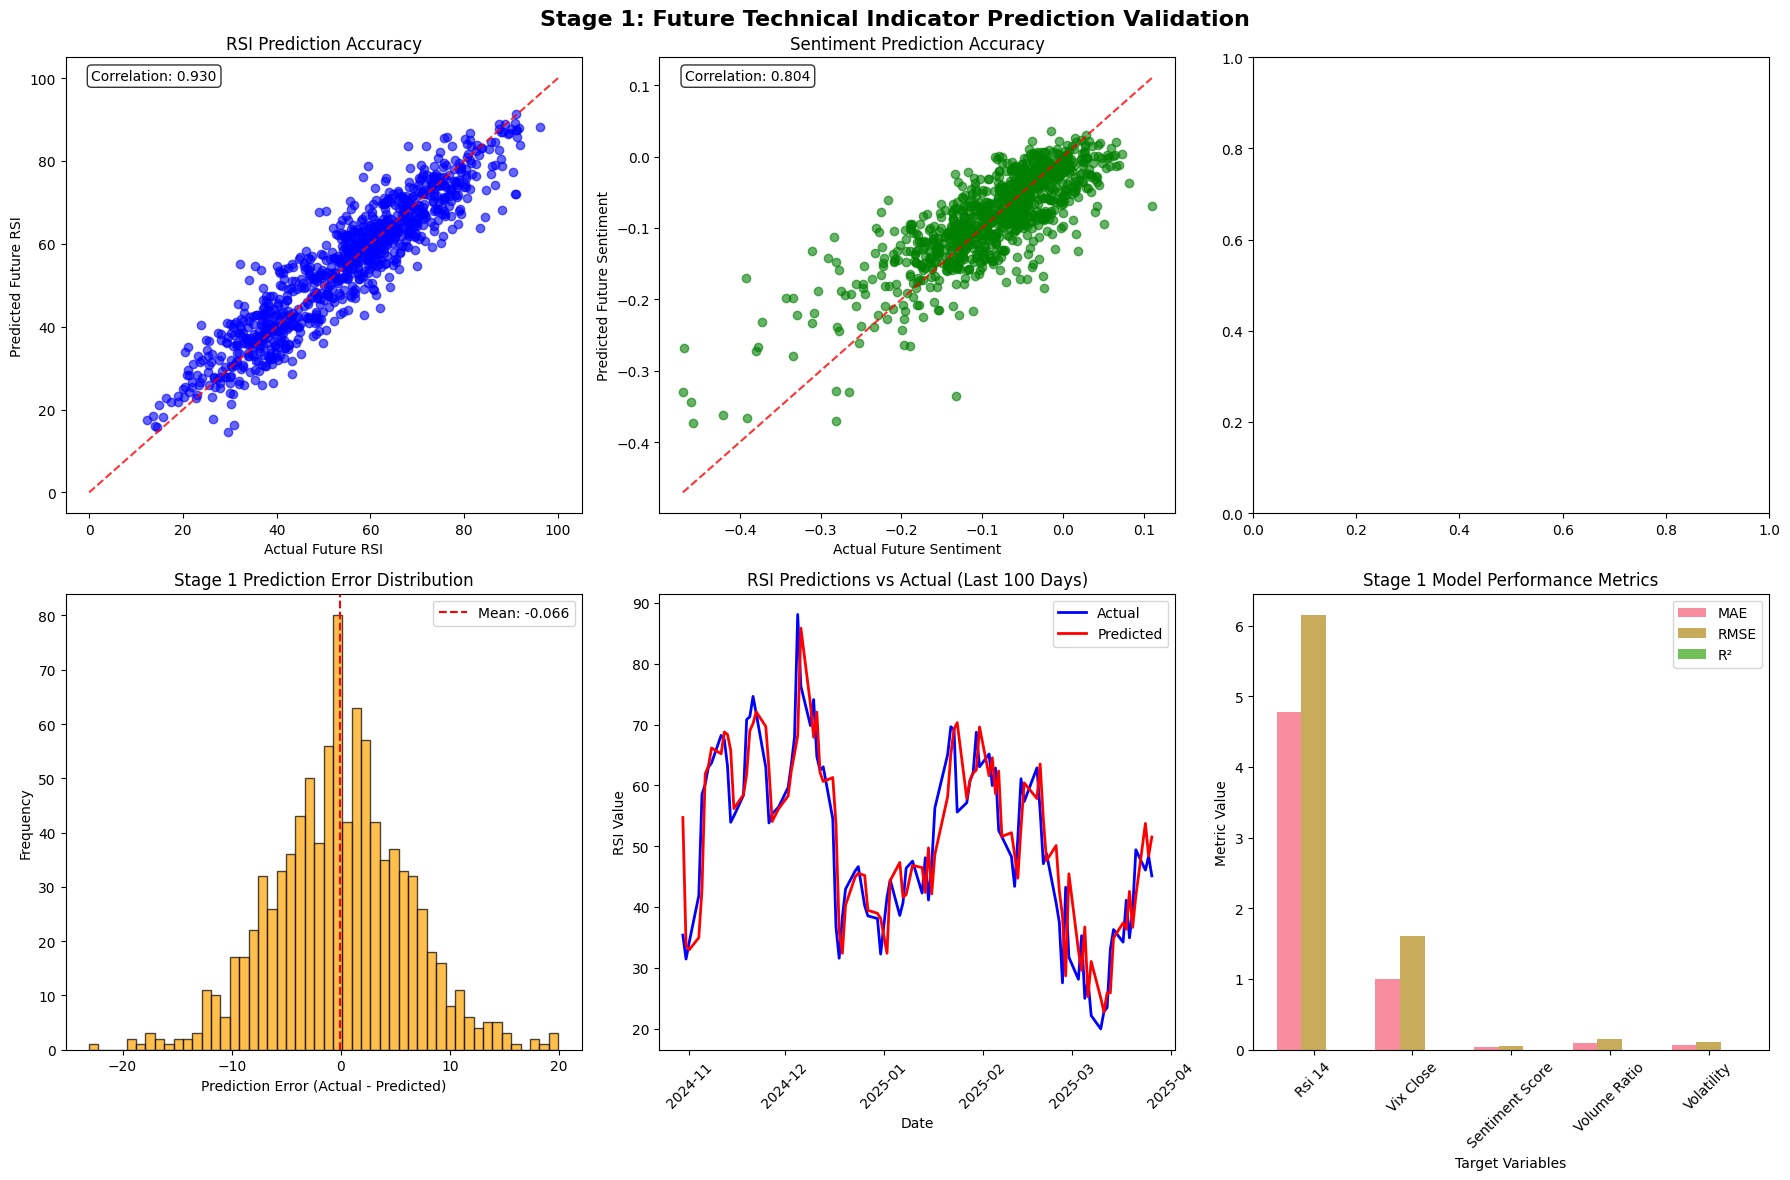


Generating Stage 2 validation plots...


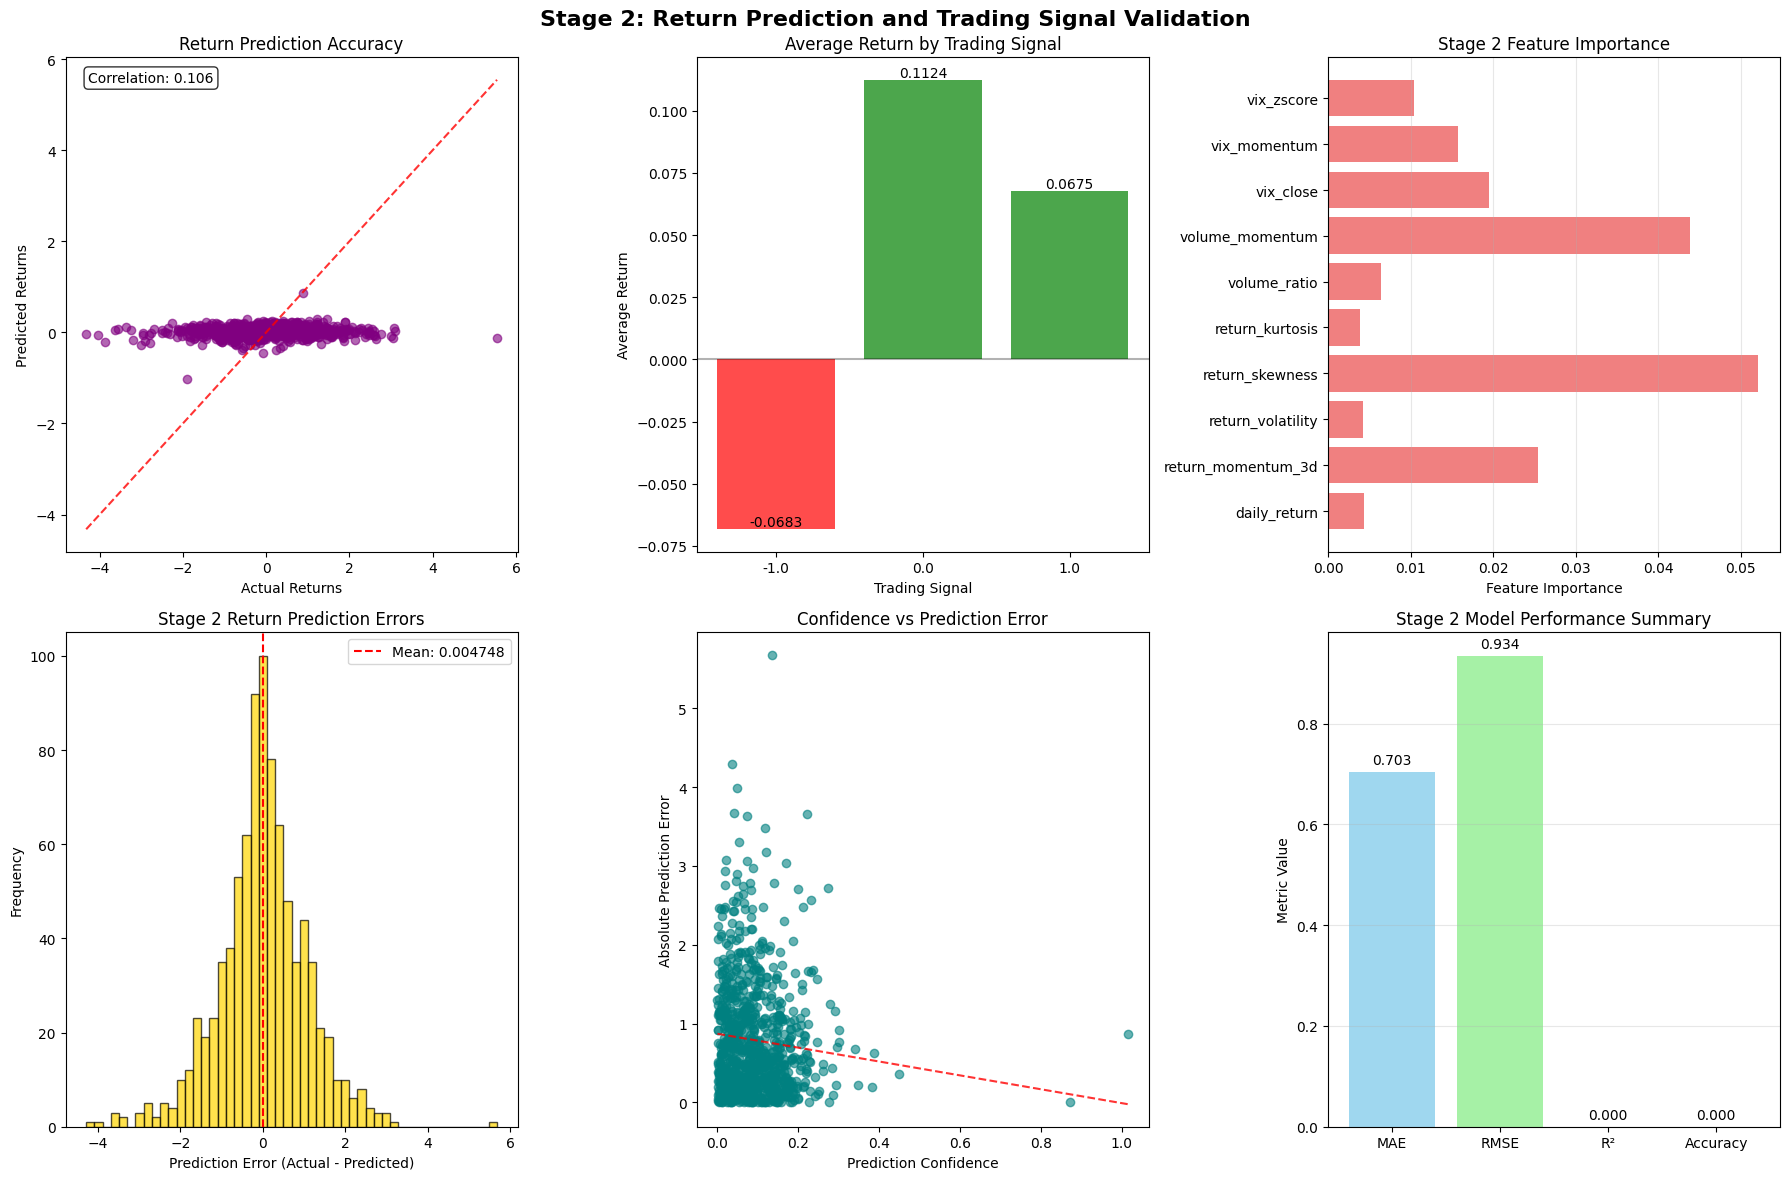

In [9]:
def plot_stage1_validation(df, stage1_results, stage1_features):
    """Plot Stage 1 model validation and performance"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Stage 1: Future Technical Indicator Prediction Validation', fontsize=16, fontweight='bold')
    
    # Plot 1: Predicted vs Actual RSI
    ax = axes[0, 0]
    if 'predicted_rsi_14' in df.columns and 'future_rsi_14' in df.columns:
        scatter = ax.scatter(df['future_rsi_14'], df['predicted_rsi_14'], alpha=0.6, c='blue')
        ax.plot([0, 100], [0, 100], 'r--', alpha=0.8)
        ax.set_xlabel('Actual Future RSI')
        ax.set_ylabel('Predicted Future RSI')
        ax.set_title('RSI Prediction Accuracy')
        # Calculate R²
        corr = df[['future_rsi_14', 'predicted_rsi_14']].corr().iloc[0,1]
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    # Plot 2: Predicted vs Actual Sentiment
    ax = axes[0, 1]
    if 'predicted_sentiment_score' in df.columns and 'future_sentiment_score' in df.columns:
        scatter = ax.scatter(df['future_sentiment_score'], df['predicted_sentiment_score'], alpha=0.6, c='green')
        min_val = min(df['future_sentiment_score'].min(), df['predicted_sentiment_score'].min())
        max_val = max(df['future_sentiment_score'].max(), df['predicted_sentiment_score'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        ax.set_xlabel('Actual Future Sentiment')
        ax.set_ylabel('Predicted Future Sentiment')
        ax.set_title('Sentiment Prediction Accuracy')
        corr = df[['future_sentiment_score', 'predicted_sentiment_score']].corr().iloc[0,1]
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    # Plot 3: Stage 1 Feature Importance
    ax = axes[0, 2]
    if stage1_results and 'rsi_14' in stage1_results:
        feature_names = stage1_features
        importances = []
        for feature in feature_names:
            if feature in df.columns:
                corr_with_target = abs(df[feature].corr(df.get('future_rsi_14', df.get('next_day_return', pd.Series([0])))))
                importances.append(corr_with_target)
            else:
                importances.append(0)
        
        bars = ax.barh(feature_names, importances, color='skyblue')
        ax.set_xlabel('Feature Importance (Correlation)')
        ax.set_title('Stage 1 Feature Importance')
        ax.grid(axis='x', alpha=0.3)
    
    # Plot 4: Prediction Error Distribution
    ax = axes[1, 0]
    if 'predicted_rsi_14' in df.columns and 'future_rsi_14' in df.columns:
        errors = df['future_rsi_14'] - df['predicted_rsi_14']
        ax.hist(errors.dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
        ax.axvline(errors.mean(), color='red', linestyle='--', label=f'Mean: {errors.mean():.3f}')
        ax.set_xlabel('Prediction Error (Actual - Predicted)')
        ax.set_ylabel('Frequency')
        ax.set_title('Stage 1 Prediction Error Distribution')
        ax.legend()
    
    # Plot 5: Time Series of Predictions
    ax = axes[1, 1]
    if 'predicted_rsi_14' in df.columns and 'future_rsi_14' in df.columns:
        sample_data = df.tail(100)  # Last 100 days
        ax.plot(sample_data.index, sample_data['future_rsi_14'], label='Actual', color='blue', linewidth=2)
        ax.plot(sample_data.index, sample_data['predicted_rsi_14'], label='Predicted', color='red', linewidth=2)
        ax.set_xlabel('Date')
        ax.set_ylabel('RSI Value')
        ax.set_title('RSI Predictions vs Actual (Last 100 Days)')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    # Plot 6: Model Performance Metrics
    ax = axes[1, 2]
    if stage1_results:
        metrics_data = []
        labels = []
        for target, results in stage1_results.items():
            if isinstance(results, dict) and 'mae' in results:
                metrics_data.append([results.get('mae', 0), results.get('rmse', 0), results.get('r2', 0)])
                labels.append(target.replace('future_', '').replace('_', ' ').title())
        
        if metrics_data:
            x = np.arange(len(labels))
            width = 0.25
            metrics_data = np.array(metrics_data)
            
            ax.bar(x - width, metrics_data[:, 0], width, label='MAE', alpha=0.8)
            ax.bar(x, metrics_data[:, 1], width, label='RMSE', alpha=0.8)
            ax.bar(x + width, metrics_data[:, 2], width, label='R²', alpha=0.8)
            
            ax.set_xlabel('Target Variables')
            ax.set_ylabel('Metric Value')
            ax.set_title('Stage 1 Model Performance Metrics')
            ax.set_xticks(x)
            ax.set_xticklabels(labels, rotation=45)
            ax.legend()
    
    plt.tight_layout()
    plt.savefig('stage1_validation_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_stage2_validation(df, stage2_results, stage2_features):
    """Plot Stage 2 model validation and performance"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Stage 2: Return Prediction and Trading Signal Validation', fontsize=16, fontweight='bold')
    
    # Plot 1: Predicted vs Actual Returns
    ax = axes[0, 0]
    if 'predicted_return' in df.columns and 'next_day_return' in df.columns:
        scatter = ax.scatter(df['next_day_return'], df['predicted_return'], alpha=0.6, c='purple')
        min_val = min(df['next_day_return'].min(), df['predicted_return'].min())
        max_val = max(df['next_day_return'].max(), df['predicted_return'].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
        ax.set_xlabel('Actual Returns')
        ax.set_ylabel('Predicted Returns')
        ax.set_title('Return Prediction Accuracy')
        corr = df[['next_day_return', 'predicted_return']].corr().iloc[0,1]
        ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes,
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    # Plot 2: Trading Signal Performance
    ax = axes[0, 1]
    if 'trading_signal' in df.columns and 'next_day_return' in df.columns:
        signal_returns = df.groupby('trading_signal')['next_day_return'].mean()
        colors = ['red' if x < 0 else 'green' for x in signal_returns.values]
        bars = ax.bar(signal_returns.index.astype(str), signal_returns.values, color=colors, alpha=0.7)
        ax.set_xlabel('Trading Signal')
        ax.set_ylabel('Average Return')
        ax.set_title('Average Return by Trading Signal')
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, signal_returns.values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001, 
                   f'{val:.4f}', ha='center', va='bottom')
    
    # Plot 3: Stage 2 Feature Importance
    ax = axes[0, 2]
    if stage2_results and isinstance(stage2_results, dict):
        if 'feature_importance' in stage2_results:
            importance_data = stage2_results['feature_importance']
            features = list(importance_data.keys())[:10]  # Top 10 features
            importances = [importance_data[f] for f in features]
        else:
            # Calculate correlation-based importance
            features = [f for f in stage2_features if f in df.columns][:10]
            importances = [abs(df[f].corr(df.get('next_day_return', pd.Series([0])))) for f in features]
        
        bars = ax.barh(features, importances, color='lightcoral')
        ax.set_xlabel('Feature Importance')
        ax.set_title('Stage 2 Feature Importance')
        ax.grid(axis='x', alpha=0.3)
    
    # Plot 4: Return Prediction Error Distribution
    ax = axes[1, 0]
    if 'predicted_return' in df.columns and 'next_day_return' in df.columns:
        errors = df['next_day_return'] - df['predicted_return']
        ax.hist(errors.dropna(), bins=50, alpha=0.7, color='gold', edgecolor='black')
        ax.axvline(errors.mean(), color='red', linestyle='--', label=f'Mean: {errors.mean():.6f}')
        ax.set_xlabel('Prediction Error (Actual - Predicted)')
        ax.set_ylabel('Frequency')
        ax.set_title('Stage 2 Return Prediction Errors')
        ax.legend()
    
    # Plot 5: Confidence vs Accuracy
    ax = axes[1, 1]
    if 'prediction_confidence' in df.columns and 'prediction_error' in df.columns:
        scatter = ax.scatter(df['prediction_confidence'], abs(df['prediction_error']), alpha=0.6, c='teal')
        ax.set_xlabel('Prediction Confidence')
        ax.set_ylabel('Absolute Prediction Error')
        ax.set_title('Confidence vs Prediction Error')
        
        # Add trend line
        valid_data = df[['prediction_confidence', 'prediction_error']].dropna()
        if len(valid_data) > 0:
            z = np.polyfit(valid_data['prediction_confidence'], abs(valid_data['prediction_error']), 1)
            p = np.poly1d(z)
            ax.plot(valid_data['prediction_confidence'].sort_values(), 
                   p(valid_data['prediction_confidence'].sort_values()), "r--", alpha=0.8)
    
    # Plot 6: Model Performance Summary
    ax = axes[1, 2]
    if stage2_results and isinstance(stage2_results, dict):
        metrics = ['MAE', 'RMSE', 'R²', 'Accuracy']
        values = [
            stage2_results.get('mae', 0),
            stage2_results.get('rmse', 0), 
            stage2_results.get('r2', 0),
            stage2_results.get('accuracy', 0)
        ]
        
        bars = ax.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold'], alpha=0.8)
        ax.set_ylabel('Metric Value')
        ax.set_title('Stage 2 Model Performance Summary')
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{val:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('stage2_validation_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate Stage 1 and Stage 2 validation plots
print("Generating Stage 1 validation plots...")
plot_stage1_validation(df_stage2, stage1_results, stage1_features)

print("\nGenerating Stage 2 validation plots...")
plot_stage2_validation(df_stage2, stage2_results, stage2_features)